In [340]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller
import numpy as np

In [302]:
# load the data
data_2019 = pd.read_csv("C:/Users/PC/Documents/Water_datasets/WaterUsage_2019.csv")
data_2020 = pd.read_csv("C:/Users/PC/Documents/Water_datasets/WaterUsage_2020.csv")
data_2021 = pd.read_csv("C:/Users/PC/Documents/Water_datasets/WaterUsage_2021.csv")
data_2022 = pd.read_csv("C:/Users/PC/Documents/Water_datasets/WaterUsage_2022.csv")
data_2023 = pd.read_csv("C:/Users/PC/Documents/Water_datasets/WaterUsage_2023.csv")

In [304]:
data_2019['Year'] = 2019
data_2020['Year'] = 2020
data_2021['Year'] = 2021
data_2022['Year'] = 2022
data_2023['Year'] = 2023

In [305]:
combined_data = pd.concat([data_2019, data_2020, data_2021, data_2022, data_2023], ignore_index=True)

In [306]:
months = ['JANUARY','FEBRUARY','MARCH','APRIL','MAY','JUNE',
          'JULY','AUGUST','SEPTEMBER','OCTOBER','NOVEMBER','DECEMBER']

In [307]:
# Make sure months are numeric
for m in months:
    combined_data[m] = pd.to_numeric(combined_data[m], errors='coerce')

In [313]:
# 2) Go to long format (Year, Month, Usage)
long = combined_data.melt(id_vars=['Year'], value_vars=months,
                         var_name='Month', value_name='Usage')

In [315]:
# month name -> number and proper Date
month_map = {m: i+1 for i, m in enumerate(months)}
long['MonthNum'] = long['Month'].map(month_map)
long['Date'] = pd.to_datetime(dict(year=long['Year'], month=long['MonthNum'], day=1))

In [317]:
# 3) Aggregate to monthly totals across all accounts, sort by Date
ts = (long.groupby('Date', as_index=False)['Usage']
           .sum()
           .sort_values('Date'))

Text(0, 0.5, 'Total Water Usage (Kl)')

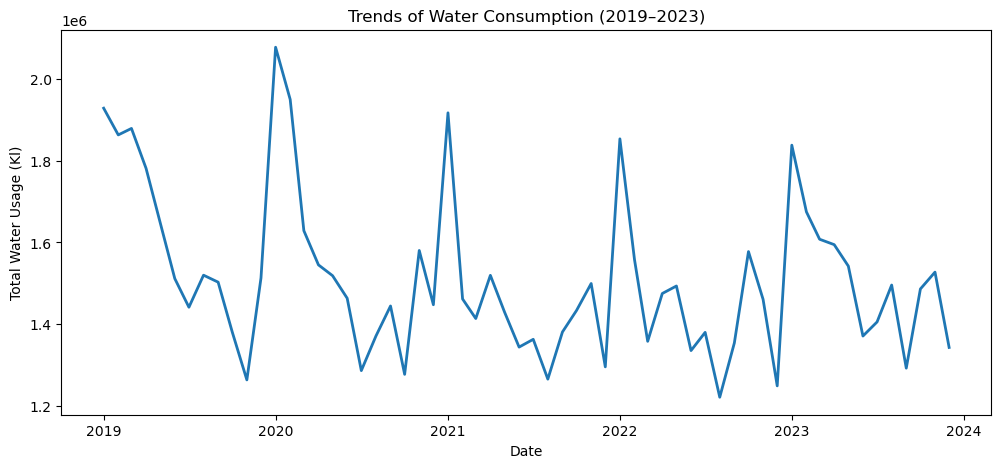

In [319]:
# 4) Plot a single trend line (2019–2023)
plt.figure(figsize=(12, 5))
plt.plot(ts['Date'], ts['Usage'], linewidth=2)  # one continuous line
plt.title('Trends of Water Consumption (2019–2023)')
plt.xlabel('Date')
plt.ylabel('Total Water Usage (Kl)')

In [321]:
roll_window = 3

In [323]:
years = sorted(ts_year['Year'].unique())
print("Years found:", years)

Years found: [2019, 2020, 2021, 2022, 2023]


In [325]:
for year in years:
    df = ts_year[ts_year['Year'] == year].copy().sort_values('Date')
    if df.empty:
        print(f"⚠️ Skipping {year}: no data")
        continue

    # Rolling mean (centered 3-month)
    df['RollingMean'] = df['Usage'].rolling(window=roll_window, min_periods=2, center=True).mean()

    # Create a fresh figure for this year
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df['Date'], df['Usage'], marker='o', label='Total Consumption')
    ax.plot(df['Date'], df['RollingMean'], linestyle='--', linewidth=2,
            label=f'{roll_window}-Month Rolling Mean')

    ax.set_title(f'Total Water Consumption & Rolling Mean — {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Consumption (Kl)')
    ax.set_xticks(df['Date'])
    ax.set_xticklabels(df['Date'].dt.strftime('%b'), rotation=45)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    fig.tight_layout()

    # Save (use fig.savefig to be explicit), then close
    file_name = f"Water_Consumption_{year}.png"
    save_path = os.path.join(save_dir, file_name)
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

    # Verify size on disk
    size_kb = os.path.getsize(save_path) / 1024
    print(f"✅ Saved: {save_path}  ({size_kb:.1f} KB)")


✅ Saved: C:\Users\PC\Documents\Water_datasets\graphs\Water_Consumption_2019.png  (218.3 KB)
✅ Saved: C:\Users\PC\Documents\Water_datasets\graphs\Water_Consumption_2020.png  (233.7 KB)
✅ Saved: C:\Users\PC\Documents\Water_datasets\graphs\Water_Consumption_2021.png  (226.5 KB)
✅ Saved: C:\Users\PC\Documents\Water_datasets\graphs\Water_Consumption_2022.png  (238.6 KB)
✅ Saved: C:\Users\PC\Documents\Water_datasets\graphs\Water_Consumption_2023.png  (228.4 KB)


In [326]:
# Sum by Year-Month to get *monthly total consumption*
monthly_totals = long.groupby(['Year', 'Month'], as_index=False)['Usage'].sum()


In [327]:
# Now compute summary stats based on those 60 totals
s = monthly_totals['Usage']

In [331]:
summary = pd.DataFrame({
    'Statistics': ['Values'],
    'N (Sample size)': [len(s)],          # should be 60
    'Mean': [s.mean()],
    'Median': [s.median()],
    'Minimum': [s.min()],
    'Maximum': [s.max()],
    'Skewness': [s.skew()],
    'Kurtosis': [s.kurt()]
}).round(3)

In [333]:
print("\n📊 Summary Based on 60 Monthly Totals (2019–2023):\n")
print(summary.to_string(index=False))


📊 Summary Based on 60 Monthly Totals (2019–2023):

Statistics  N (Sample size)        Mean      Median     Minimum     Maximum  Skewness  Kurtosis
    Values               60 1510797.533 1480730.353 1221615.159 2077254.989     1.038     0.613


In [338]:
# long format: Year–Month–Account
long = (combined_data
        .melt(id_vars=['Year'], value_vars=months,
              var_name='Month', value_name='Usage')
        .dropna(subset=['Usage']))

# month name -> number and proper Date
month_map = {m: i+1 for i, m in enumerate(months)}
long['MonthNum'] = long['Month'].map(month_map)
long['Date'] = pd.to_datetime(dict(year=long['Year'], month=long['MonthNum'], day=1))

# aggregate across all accounts per month
monthly_df = (long.groupby('Date', as_index=False)['Usage']
                   .sum()
                   .sort_values('Date'))

# make a 1-D numeric Series with Date index
series = pd.Series(monthly_df['Usage'].astype('float64').values,
                   index=monthly_df['Date'])
series = series.dropna()

# sanity checks (helpful)
print("Series type:", type(series), "shape:", series.shape)
print("First 5 points:\n", series.head())
print("Count:", series.size)         # should be ~60
print("Is monotonic by date:", series.index.is_monotonic_increasing)

# 2) ADF test
adf_stat, pval, used_lags, nobs, crit_vals, icbest = adfuller(series.values)

print("\n📊 Augmented Dickey-Fuller (ADF) Test Results")
print(f"ADF Statistic: {adf_stat:.4f}")
print(f"p-value: {pval:.4f}")
print(f"Lags Used: {used_lags}")
print(f"Observations Used: {nobs}")
for k, v in crit_vals.items():
    print(f"Critical Value ({k}): {v:.4f}")
print("\n", "✅ Stationary (reject H0)" if pval <= 0.05 else "⚠️ Non-stationary (fail to reject H0)")

Series type: <class 'pandas.core.series.Series'> shape: (60,)
First 5 points:
 Date
2019-01-01    1.928232e+06
2019-02-01    1.862893e+06
2019-03-01    1.878713e+06
2019-04-01    1.781076e+06
2019-05-01    1.648307e+06
dtype: float64
Count: 60
Is monotonic by date: True

📊 Augmented Dickey-Fuller (ADF) Test Results
ADF Statistic: -1.5936
p-value: 0.4868
Lags Used: 11
Observations Used: 48
Critical Value (1%): -3.5746
Critical Value (5%): -2.9240
Critical Value (10%): -2.6000

 ⚠️ Non-stationary (fail to reject H0)


In [350]:
# --- 1️⃣ Compute Z-scores ---
z = (series - series.mean()) / series.std()

In [352]:
# --- 2️⃣ Flag anomalies (change threshold if needed) ---
threshold = 2.5  # 2.0 for sensitive, 3.0 for strict
anomalies = series[np.abs(z) >= threshold]

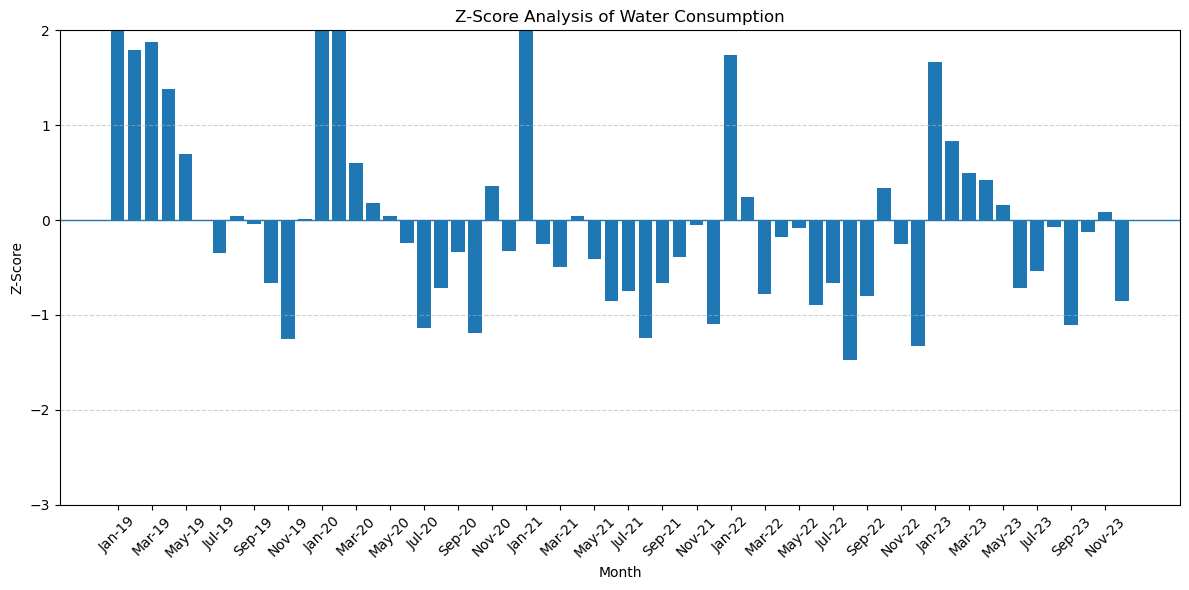

In [354]:
# ---------- 3) Plot to match your example (bar, baseline at 0) ----------
x = np.arange(len(z))
labels = [d.strftime('%b-%y') for d in series.index]

plt.figure(figsize=(12,6))
plt.bar(x, z)                       # single color bars like your image
plt.axhline(0, linewidth=1)         # baseline at zero
plt.ylim(-3, 2)                     # adjust if you want a different range
plt.title('Z-Score Analysis of Water Consumption')
plt.xlabel('Month')
plt.ylabel('Z-Score')
# show every 2nd tick to avoid clutter
step = 2
plt.xticks(x[::step], labels[::step], rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()